# Group 7
Feb 25, 2022 


# Problem Defining
Airbnb is a game-changer in traditional hospitality businesses, providing guests with a more distinctive and personalized option of traveling and experiencing the world. We'd want to explore the pricing listings in the Manhattan area and develop a price prediction for travelers to use when deciding where to stay. In addition, we'd want to dig into the common features of popular listings and make some recommendations to (prospective)/ hosts on how to make their listings popular.

Our dataset comes from the U.S. Airbnb Open Data source in  Kaggle
(https://www.kaggle.com/kritikseth/us-airbnb-open-data), which originally is a compilation of multiple datasets found on Inside Airbnb.  (http://insideairbnb.com/index.html).
This dataset provides us the information of Airbnb listings in the U.S. with attributes including the ID, name, room type(Entire home, shared room, private room, Hotel room), and price of the listing; ID and name of the host; where the listing located at (neighborhood, latitude-longitude, city), reviews, and the number of days in a year the listing is available for rent.

Occupancy = ((review per month * minimum nights)*12) /availability 365

In [1]:
# Libraries And Utilities
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from wordcloud import WordCloud,STOPWORDS

import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

In [2]:
#importing data
raw_data = pd.read_csv('AB_US_2020.csv')
raw_data.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226030 entries, 0 to 226029
Data columns (total 17 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              226030 non-null  int64  
 1   name                            226002 non-null  object 
 2   host_id                         226030 non-null  int64  
 3   host_name                       225997 non-null  object 
 4   neighbourhood_group             110185 non-null  object 
 5   neighbourhood                   226030 non-null  object 
 6   latitude                        226030 non-null  float64
 7   longitude                       226030 non-null  float64
 8   room_type                       226030 non-null  object 
 9   price                           226030 non-null  int64  
 10  minimum_nights                  226030 non-null  int64  
 11  number_of_reviews               226030 non-null  int64  
 12  last_review     

In [4]:
# Subset the DataFrame to include only data about Manhattan with availability to be booked
# Creating new dataframe
df_Manhattan = raw_data.loc[(raw_data["neighbourhood_group"] == "Manhattan") & (raw_data["city"] == "New York City")
                            & (raw_data["availability_365"] > 0)]
df_Manhattan.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
117155,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,175,3,48,04/11/19,0.37,2,365,New York City
117159,5178,Large Furnished Room Near B'way„ÄÄ,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,473,15/03/20,3.42,1,346,New York City
117161,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,140,1,161,29/07/19,1.20,4,288,New York City


<AxesSubplot:>

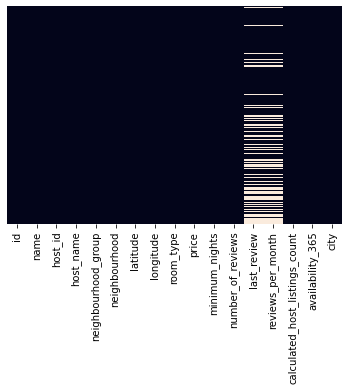

In [5]:
sns.heatmap(df_Manhattan.isnull(),yticklabels=False,cbar=False)

In [6]:
# Column last_review containing missing values due to lacking reviews
# Fill missing values
df_Manhattan['reviews_per_month'] = df_Manhattan['reviews_per_month'].replace(np.nan, 0)

In [7]:
# Occupancy = ((review per month * minimum nights)*12) /availability 365
df_Manhattan['occupancy'] = df_Manhattan['reviews_per_month'] * df_Manhattan['minimum_nights'] * 12 / df_Manhattan['availability_365']

In [8]:
# Convert to Numeric
# creating instance of labelencoder
room_type_dum = pd.get_dummies(df_Manhattan.room_type)
mergedum = pd.concat([df_Manhattan, room_type_dum], axis='columns')
df_clean = mergedum.drop('room_type', axis='columns')

In [9]:
df_clean.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,...,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city,occupancy,Entire home/apt,Hotel room,Private room,Shared room
117155,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,175,3,...,04/11/19,0.37,2,365,New York City,0.036493,1,0,0,0
117159,5178,Large Furnished Room Near B'way„ÄÄ,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,79,2,...,15/03/20,3.42,1,346,New York City,0.237225,0,0,1,0
117161,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,140,1,...,29/07/19,1.20,4,288,New York City,0.050000,1,0,0,0
117162,5552,Spacious river view in the West Village,8380,Maria,Manhattan,West Village,40.73552,-74.01042,160,3,...,10/08/19,0.49,1,96,New York City,0.183750,1,0,0,0
117164,6021,Wonderful Guest Bedroom in Manhattan CENTRAL PARK,11528,Claudio,Manhattan,Upper West Side,40.79826,-73.96113,85,2,...,09/12/19,0.89,1,365,New York City,0.058521,0,0,1,0


# Exploratory Data Analysis

<AxesSubplot:xlabel='price', ylabel='Density'>

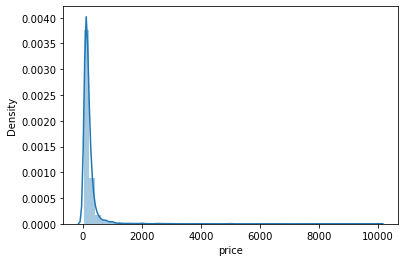

In [10]:
sns.distplot(df_clean['price'])

In [11]:
#find possible outliers
#boxplot of columns
df_clean["price"].describe()

count    11226.000000
mean       203.030732
std        365.278039
min         17.000000
25%         85.000000
50%        134.000000
75%        215.000000
max      10000.000000
Name: price, dtype: float64

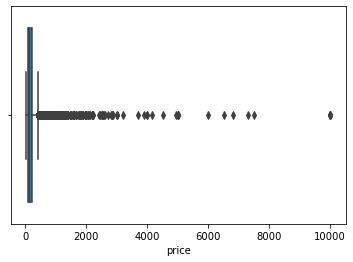

In [12]:
boxplot = sns.boxplot(x=df_clean["price"])

In [13]:
# For Skewed distribution
# Use Inter-Quartile Range proximity rule to remove Outliers

IQR = 215 - 85
df_clean = df_clean.loc[(df_clean["price"] < 215 + 1.5 * IQR)]

<AxesSubplot:xlabel='price', ylabel='Density'>

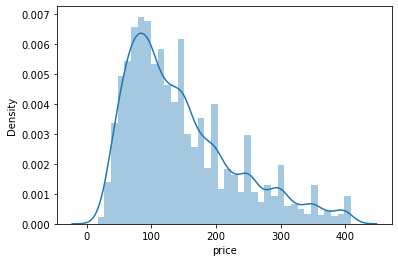

In [14]:
sns.distplot(df_clean['price'])

<AxesSubplot:>

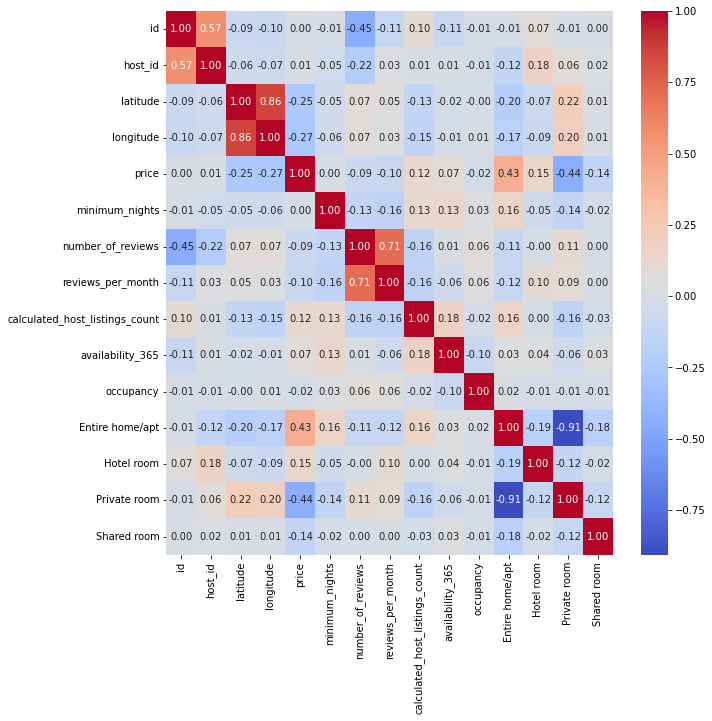

In [15]:
plt.rcParams['figure.figsize']=10,10
sns.heatmap(df_clean.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

# Text Based Analysis

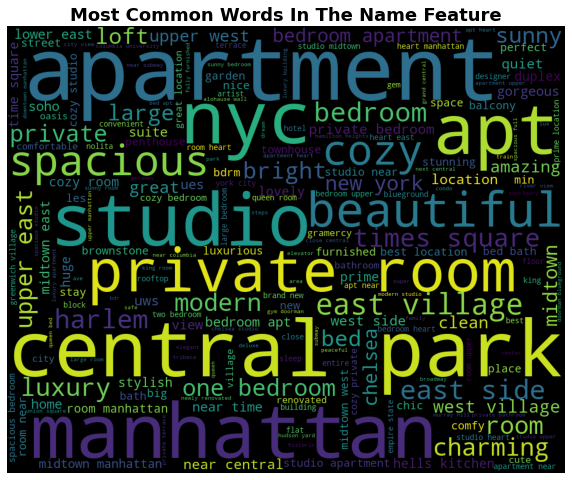

In [16]:
stopwords = list(STOPWORDS)

# to lower case
df_clean['name'] = df_clean['name'].str.lower()

# regular expression
regex = re.compile('[^a-z\s]')
# cast everything in column name as string object
df_clean['name'] = df_clean['name'].apply(lambda x: regex.sub('', str(x)))
names = ' '.join(df_clean['name'].values)
names = re.sub("^\d+\s|\s\d+\s|\s\d+$", "", names)
names = re.findall(r'\w+', names)
names = ' '.join([word for word in names if word not in stopwords and len(word) >2])

# Count frequency to show most common words
names_freq_dic = nltk.FreqDist(names.split(' '))
dict(names_freq_dic)

plt.imshow(WordCloud(width=1000,height=800,min_font_size=10,stopwords=stopwords).generate(names))
plt.title('Most Common Words In The Name Feature',fontsize=18,fontweight='bold')
plt.axis('off')
plt.show()

In [ ]:
X = df_clean[[ 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'occupancy', 'Entire home/apt', 'Hotel room', 'Private room',
       'Shared room']]
X

In [29]:
df_clean

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,...,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city,occupancy,Entire home/apt,Hotel room,Private room,Shared room
117155,2595,skylit midtown castle,2845,Jennifer,Manhattan,Midtown,40.753620,-73.983770,175,3,...,04/11/19,0.37,2,365,New York City,0.036493,1,0,0,0
117159,5178,large furnished room near bway,8967,Shunichi,Manhattan,Hell's Kitchen,40.764890,-73.984930,79,2,...,15/03/20,3.42,1,346,New York City,0.237225,0,0,1,0
117161,5238,cute cozy lower east side bdrm,7549,Ben,Manhattan,Chinatown,40.713440,-73.990370,140,1,...,29/07/19,1.20,4,288,New York City,0.050000,1,0,0,0
117162,5552,spacious river view in the west village,8380,Maria,Manhattan,West Village,40.735520,-74.010420,160,3,...,10/08/19,0.49,1,96,New York City,0.183750,1,0,0,0
117164,6021,wonderful guest bedroom in manhattan central park,11528,Claudio,Manhattan,Upper West Side,40.798260,-73.961130,85,2,...,09/12/19,0.89,1,365,New York City,0.058521,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162904,45326314,cozy apartment near grand central,226519844,Lidiya,Manhattan,Murray Hill,40.749950,-73.979190,124,1,...,NaN,0.00,1,365,New York City,0.000000,1,0,0,0
162906,45327718,spacious queen bedroom in central park,305240193,June,Manhattan,Harlem,40.802660,-73.958360,53,30,...,NaN,0.00,60,365,New York City,0.000000,0,0,1,0
162908,45329491,spacious queen bedroom in tribeca,305240193,June,Manhattan,Tribeca,40.713630,-74.008470,70,30,...,NaN,0.00,60,364,New York City,0.000000,0,0,1,0
162909,45329984,spacious full bedroom in murray hill,305240193,June,Manhattan,Kips Bay,40.744800,-73.977500,59,30,...,NaN,0.00,60,365,New York City,0.000000,0,0,1,0


# Model Selection And Evaluation

## Linear regression

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

In [82]:
X = df_clean.drop('price', axis = 1)
y = df_clean['price']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state = 101)

In [84]:
#1. identify numerical and categorical cols :
numerical_cols = [cname for cname in X.columns if 
                X[cname].dtype in ['int64', 'float64']]

categorical_cols = [cname for cname in X.columns if
                    X[cname].nunique() < 50 and 
                    X[cname].dtype in ['object', 'bool']]

In [85]:
#2. set up pipelines to transform numerical & categorical data :
# Also pipelines are valuable for cleaning up machine learning code and avoiding errors, 
# and are especially useful for workflows with sophisticated data preprocessing. 

numerical_transformer = SimpleImputer(strategy='constant')

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(sparse = False, handle_unknown = 'ignore'))
])



In [86]:
#3. Tranforming columns both numeric & categorical :
preprocessor = ColumnTransformer(transformers = [
    ('num',  numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])


In [87]:
#4. Import model and set up Hyperparameteres : 
model = XGBRegressor(base_score = 0.5, booster = 'gbtree', colsample_bylevel = 1,
                     colsample_bynode = 1, colsample_bytree = 0.6, gamma = 0.0, gpu_id = -1,
                     importance_type = 'gain', interaction_constraints = '',
                     learning_rate = 0.02, max_delta_step = 0, max_depth = 4,
                     min_child_weight = 0.0, n_estimators = 1250, n_jobs = 0, 
                     num_parallel_tree = 1, random_state = 0,
                     reg_alpha = 0, reg_lambda = 1, scale_pos_weight = 1, subsample=0.8,
                     tree_method = 'exact', validate_parameters = 1, verbosity=None )

In [88]:
#5. Putting it together
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

clf.fit(X_train, y_train, model__verbose=False) 
preds = clf.predict(X_test)


print('RMSE:', mean_squared_error(y_test, preds, squared = False))

RMSE: 68.13929866855878


## K-nearest neighbors (KNN)

In [25]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline 
from sklearn.metrics import (f1_score,confusion_matrix,
                             precision_score,recall_score, classification_report)

In [62]:
from sklearn.preprocessing import MinMaxScaler
X = df_clean[[ 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'occupancy', 'Entire home/apt', 'Hotel room', 'Private room',
       'Shared room']]
y = df_clean['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state = 101)
scaler = MinMaxScaler()
scaler.fit(X_train)
scaled_x_test=scaler.transform(X_test)
scaled_x_train=scaler.transform(X_train)

RMSE value for k=  0 is: 89.13797654953866
RMSE value for k=  1 is: 79.12354996462072
RMSE value for k=  2 is: 75.35680511537078
RMSE value for k=  3 is: 73.07736042469736
RMSE value for k=  4 is: 71.9024904671372
RMSE value for k=  5 is: 70.82569293679586
RMSE value for k=  6 is: 70.41298710717895
RMSE value for k=  7 is: 70.04520115853789
RMSE value for k=  8 is: 69.79807624330891
RMSE value for k=  9 is: 69.43093520707643
RMSE value for k=  10 is: 69.08190138779467
RMSE value for k=  11 is: 69.14275991632839
RMSE value for k=  12 is: 68.88459369030467
RMSE value for k=  13 is: 68.95651811953309
RMSE value for k=  14 is: 68.96816097742435
RMSE value for k=  15 is: 68.91424898656318
RMSE value for k=  16 is: 68.82804608403919
RMSE value for k=  17 is: 68.86854620606037
RMSE value for k=  18 is: 68.86781967239689
RMSE value for k=  19 is: 68.90565496097004
RMSE value for k=  20 is: 68.88920328596123


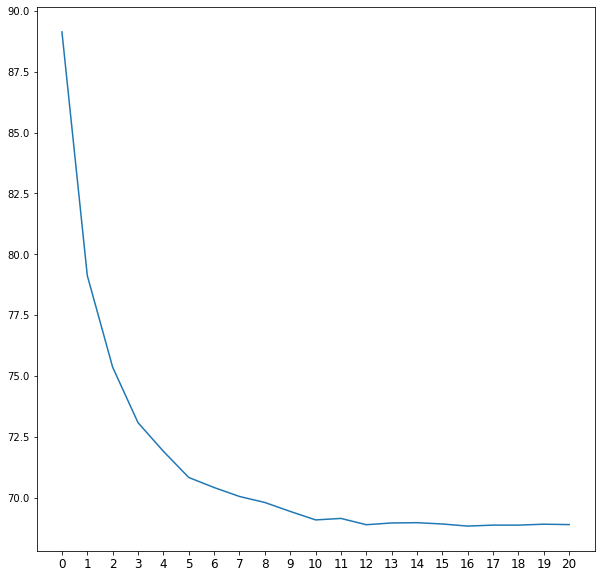

In [70]:
#import required packages
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt
from math import sqrt
rmse_val = [] #to store rmse values for different k
for K in range(1,22):  
    model = KNeighborsRegressor(n_neighbors = K)
    model.fit(scaled_x_train, y_train)  #fit the model
    pred=model.predict(scaled_x_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K-1 , 'is:', error)

plt.plot(rmse_val)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],fontsize=12)
plt.show()

In [71]:
from sklearn.model_selection import GridSearchCV
model = KNeighborsRegressor()
grid_params = {
    'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,18, 19, 20],
    'weights': ['distance'],
    'metric': ['euclidean', 'manhattan']
}

gs = GridSearchCV(KNeighborsRegressor(),
                  grid_params,
                  verbose=1,
                  cv=3,
                  n_jobs=-1)

gs_results = gs.fit(scaled_x_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


In [72]:
pred = gs.predict(scaled_x_test)
error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
rmse_val.append(error) #store rmse values
print('RMSE value for k= ' , gs_results.best_estimator_.n_neighbors , 'is:', error)

RMSE value for k=  20 is: 68.23747016255754


In [73]:
# gs_results.best_score_

0.3509425984502414

In [74]:
# gs_results.best_estimator_

KNeighborsRegressor(metric='manhattan', n_neighbors=20, weights='distance')

In [75]:
# gs_results.best_params_

{'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}

## Bag of words

In [45]:
import re

df_Manhattan['name'] = df_Manhattan['name'].str.lower()
#choose everyting except alphabetical characters, spaces or tabs.
regex = re.compile('[^a-z\s]')
#substitude non-alphabetical characteres with nothing
df_Manhattan['name'] = df_Manhattan['name'].apply(lambda x: regex.sub('', str(x)))

df_Manhattan['unigrams'] = df_Manhattan['name'].apply(nltk.word_tokenize)
#excude words that are in stop_words and its length is less than 2
df_Manhattan['unigrams'] = df_Manhattan['unigrams'].apply(lambda x: [word for word in x 
                                            if word not in stopwords and len(word)>2])
df_Manhattan['unigrams']

117155                            [skylit, midtown, castle]
117159                 [large, furnished, room, near, bway]
117161                [cute, cozy, lower, east, side, bdrm]
117162               [spacious, river, view, west, village]
117164    [wonderful, guest, bedroom, manhattan, central...
                                ...                        
162904              [cozy, apartment, near, grand, central]
162906            [spacious, queen, bedroom, central, park]
162908                  [spacious, queen, bedroom, tribeca]
162909              [spacious, full, bedroom, murray, hill]
162910                 [cozy, studio, brand, new, building]
Name: unigrams, Length: 11226, dtype: object

In [47]:
#count frequency of each word appeard in 'unigrams' column in descending order
count=pd.Series(np.concatenate([x for x in df_Manhattan.unigrams])).value_counts()
count = pd.DataFrame({'unigrams': list(count.keys()),
                   'count': list(count[:])})
#take 30 most frequent words
most_common = count[:30]
most_common

,unigrams,count
0,room,1911
1,bedroom,1850
2,apartment,1403
3,private,1340
4,studio,1330
5,east,1133
6,manhattan,1099
7,apt,1020
8,park,943
9,cozy,931


## Summary